# 以房价预测为例对数据进行探究

原题是：[House Prices - Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques)。

本文主要关注挖掘数据中的信息，不涉及神经网络模型的构建。译改自：[Comprehensive data exploration with Python - Pedro Marcelino, PhD](https://www.kaggle.com/code/pmarcelino/comprehensive-data-exploration-with-python/notebook)。

In [1]:
#invite people for the Kaggle party
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline


Bad key text.latex.unicode in file C:\ProgramData\miniconda3\envs\gluon\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 112 ('text.latex.unicode : False # use "ucs" and "inputenc" LaTeX packages for handling')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.frameon in file C:\ProgramData\miniconda3\envs\gluon\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 423 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution

Bad key pgf.debug in file C:\ProgramData\miniconda3\envs\gluon\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 444 ('pgf.debug           : False')
You probably need to get an updated matplotlibrc file 

## 解析数据

In [2]:
#bring in the six packs
df_train = pd.read_csv('../data/kaggle_house_pred_train.csv')


#check the decoration
df_train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

## 初步分析特征

进行深度学习前，需要先对数据有初步的了解，可以从以下几个方面入手。

* **特征**：特征的名字
* **数据类型**：有两类数据，离散数据与量化数据。
* **特征分类**：将特征进行分类，在“房价预测”中，可以将变量分为building、space、location三类。“building”指与房子的物理特征有关（如房子的质量），“space”指与房子大小有关的特征，“location”指与房子位置有关的特征。“space”可以理解为“building”的一个特例，但因为它的种类较多，于是把它单独拿出来当了一类。
* **预期影响**：我们可以凭借经验先给这些特征赋予对房价影响“高”“中”“低”的预期。我们后期可以优先重点关注这些变量的拟合情况。

在房价预测中，经过初步分析，认为以下的特征可能对房价有较高的影响。
* OverallQual（总的房屋质量，这个特征事实中难以量化qwq，但题目中有提供，其实可以利用其他的“building”特征，再建立一个模型来拟合，当然这是后话）
* YearBuilt（建造时间）
* TotalBsmtSF（总地下室面积）
* GrLivArea（总生活区域面积）

在这里的预期影响中，选择两个“building”特征，两个“space”特征。但没有“location”特征，毕竟是初步的筛选，对于这些离散的数据难以直接归纳。

## 分析预测结果

我们预测的是最终的房价。那么我们可以先看下房价的一些分布信息。

In [3]:
df_train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

~买房还确实是不容易~

<AxesSubplot:xlabel='SalePrice', ylabel='Count'>

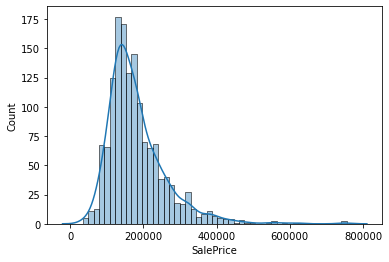

In [4]:
sns.histplot(df_train['SalePrice'], alpha=0.4, kde=True, kde_kws={"cut": 3})

seaborn的这个模块实在是优雅！
通过图像：
* 房价的分布偏离了正态分布(Deviate from the normal distribution)
* 具有明显的正偏斜度（高峰偏左，长尾向右延伸，Positive skewness）
* 展示了房价的峰度（Peakedness，Kurtosis）

In [5]:
print("Skewness: %f" % df_train['SalePrice'].skew())
print("Kurtosis: %f" % df_train['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


## 分析特征
### 量化特征

我们可以从刚才分析的对房价有较高影响的特诊入手。

首先是总生活区域面积：

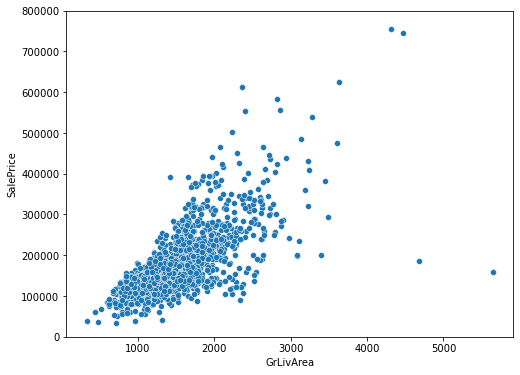

In [6]:
#scatter plot grlivarea/saleprice
var = 'GrLivArea'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.scatterplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);


很明显，总生活区域面积与房价有一定的线性相关性。

下面看看总地下室面积：

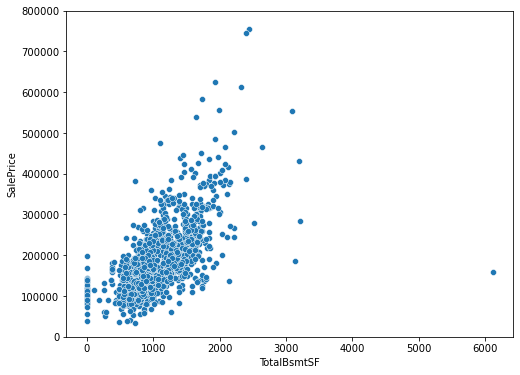

In [7]:
#scatter plot totalbsmtsf/saleprice
var = 'TotalBsmtSF'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.scatterplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);


看上去总地下室面积与房价有很强的线性相关性。当然还要关注没有地下室的可能性。

### 离散特征

房屋质量：

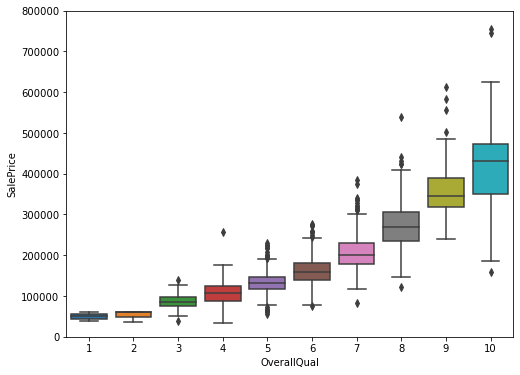

In [8]:
#box plot overallqual/saleprice
var = 'OverallQual'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

房屋的建造时间

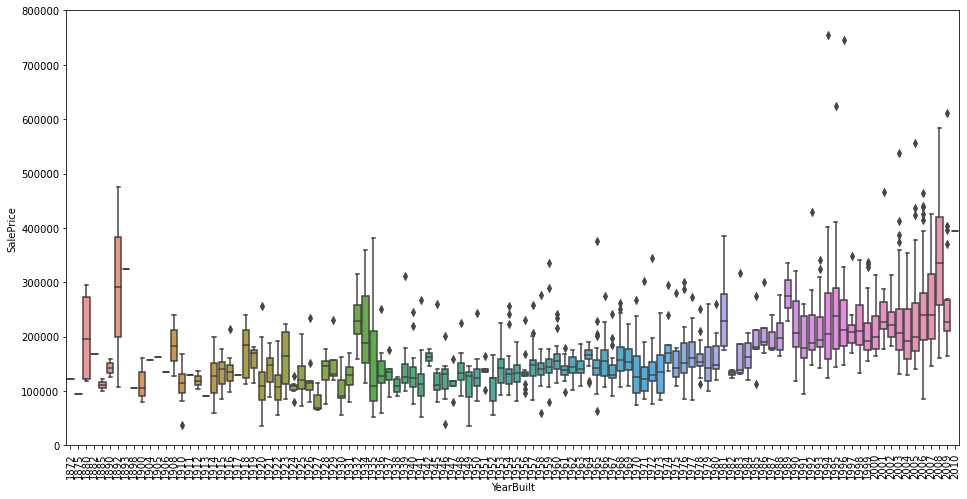

In [9]:
var = 'YearBuilt'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);
plt.xticks(rotation=90);

相关性没有那么明确，但是还是可以看出来新房子会更受欢迎，当然一些特别老的房子也可能有较高的价值。

总的来说：
* 总生活区域面积与总地下室面积与房价呈正关系。
* 房屋质量与房屋的建造时间与房价也有一定关系，房屋质量与房价关系更大。

## 深入分析特征

到上一步之前我们都是凭借主观想法选择了四个特征。但是主观的选择往往没有说服力，我们需要一种量化方式。

可以使用关系矩阵（Correlation matrix），将它以热力图的形式画出来。


<AxesSubplot:>

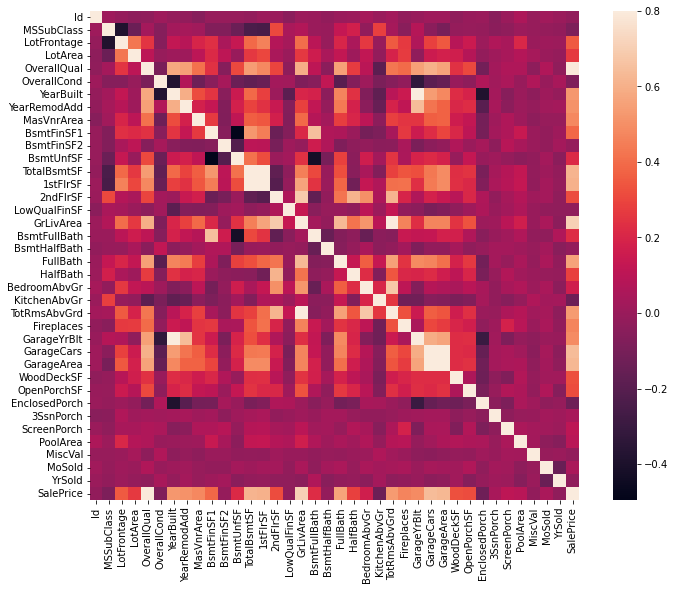

In [10]:
#correlation matrix
corrmat = df_train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)

我们观察最后一列（行），描述的是不同特征与房价的相关性，越亮代表相关性越强。

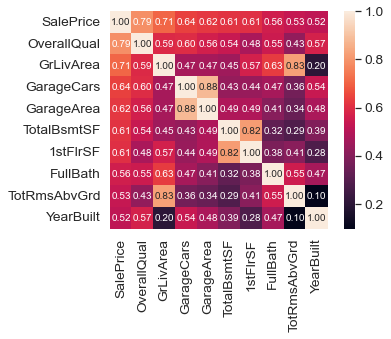

In [11]:
#saleprice correlation matrix
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

根据上面的热力图，我们得出以下的结论：
* 房屋质量（OverallQual）、总的生活区面积（GrLivArea）、总的地下空间面积（TotalBsmtSF）与房价存在很强的相关性
* 车库的容量（GarageCars）和车库大小（GarageArea）与房价存在较强的相关性，当然这两个特征之间也存在很强的相关性，面积越大的车库自然可以容纳下更多的车
* 地上总房间（TotRmsAbvGrd）和总的生活区面积（GrLivArea）有很强的相关性
* 总地下室面积 （TotalBsmtSF） 和 第一层面积（1stFloor） 也有很强的相关性

我们还可以用散点图（Scatter Plot）来描述：

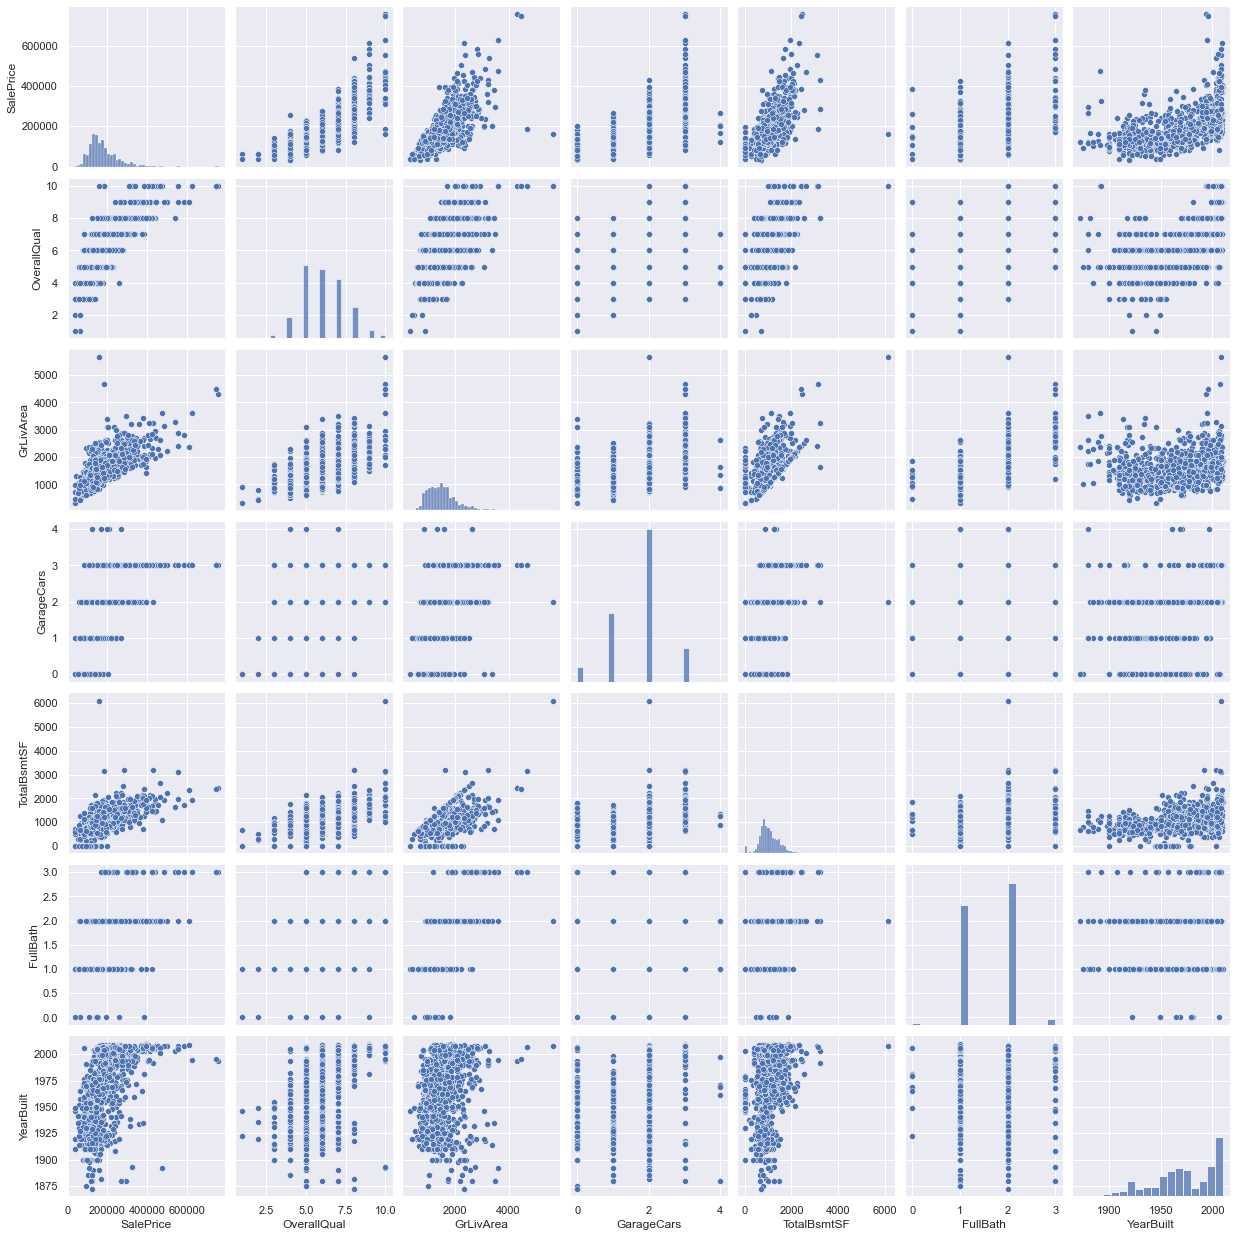

In [12]:
#scatterplot
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
fig=sns.pairplot(df_train[cols], height = 2.5)
plt.show();

通过上图，我们可以很清楚地看到离散数据的一些相关性。最为明显的是总地下室面积 （TotalBsmtSF）和总的生活区面积（GrLivArea）的关系图，所有的点仿佛落在了一条线的下面。这也很好理解，因为地下空间再大，一般也不会比生活区域大，除非你把你家做成了掩体。

## 处理缺失的数据

对于缺失的数据有两个重要问题要思考：
* 数据的缺失有多严重？
* 数据的缺失是否存在规律？

这两个问题的答案非常重要，因为缺失数据可能导致样本数的大减。此外，从问题的实质出发，我们需要保证缺失的数据没有我们没发现的隐藏信息。



In [13]:
#missing data
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageCond,81,0.055479
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479


下面是一种处理缺失数据的策略。
* 对于缺失超过15%的特征，直接删除，假装从未存在。这一类的数据，也有可能是与预测结果相关性极弱的。
* 上图中，我们可以看到与车库有关（Garage*）的数据缺失率是一致的，这就是数据缺失存在的规律，因为车库有关的1特征最重要的是“车库容量”，那么车库其他的细节信息可以删去。同样的逻辑可以应用于地下室的有关特征。
* 对于装饰石材有关特征（MasVnr*）可以认为这种特征在建造时间和房屋质量里面已经得到描述了，那么也可以删去这个特征。
* 对于电力（Electrical），仅有唯一缺失，我们删去这一样本即可，不需要删去特征。

总的来说，对于缺失较多的，在不影响大局的情况下，可以考虑直接删去这个特征。如果缺失较少，可以考虑删去样本。


In [14]:
#dealing with missing data
df_train = df_train.drop((missing_data[missing_data['Total'] > 1]).index,1)
df_train = df_train.drop(df_train.loc[df_train['Electrical'].isnull()].index)
df_train.isnull().sum().max() #just checking that there's no missing data missing...

0

## 找出liars

样本中可能存在偏离中心特别多的样本，他们的存在可能会严重影响最终模型的准确性。


In [15]:
#standardizing data
saleprice_scaled = StandardScaler().fit_transform(df_train['SalePrice'][:,np.newaxis]);
low_range = saleprice_scaled[saleprice_scaled[:,0].argsort()][:10]
high_range= saleprice_scaled[saleprice_scaled[:,0].argsort()][-10:]
print('outer range (low) of the distribution:')
print(low_range)
print('\nouter range (high) of the distribution:')
print(high_range)

outer range (low) of the distribution:
[[-1.83820775]
 [-1.83303414]
 [-1.80044422]
 [-1.78282123]
 [-1.77400974]
 [-1.62295562]
 [-1.6166617 ]
 [-1.58519209]
 [-1.58519209]
 [-1.57269236]]

outer range (high) of the distribution:
[[3.82758058]
 [4.0395221 ]
 [4.49473628]
 [4.70872962]
 [4.728631  ]
 [5.06034585]
 [5.42191907]
 [5.58987866]
 [7.10041987]
 [7.22629831]]


我们再回头看看之前的散点图

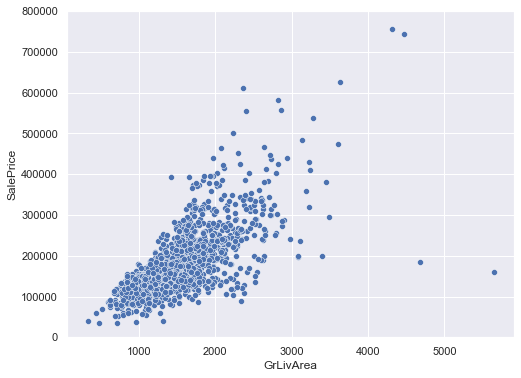

In [17]:
#scatter plot grlivarea/saleprice
var = 'GrLivArea'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.scatterplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

很明显右边有两个点偏离了中心，我们可以去除。至于数据偏离的原因，可能很多，这里不过多讨论。

In [20]:
#deleting points
df_train.sort_values(by = 'GrLivArea', ascending = False)[:2]
df_train = df_train.drop(df_train[df_train['Id'] == 1299].index)
df_train = df_train.drop(df_train[df_train['Id'] == 524].index)

以同样的方式分析地下室空间

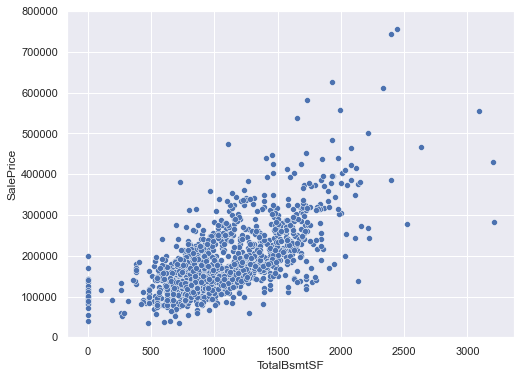

In [22]:
#scatter plot totalbsmtsf/saleprice
var = 'TotalBsmtSF'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.scatterplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);


目测并没有严重的偏离，姑且全部保留。

## 为深度学习做好准备

将数据喂给深度学习网络前，我们需要将数据进行一些处理。

数据需要满足四个假设：

* **正态性**（Normality）：简单说，就是数据的分布“像”一个正态分布。
* **等方差**（Homoscedasticity）： 我们希望变量的所有值的误差项都是相同的，不会因为度量的问题导致某个特征占了主导。 
* **线性性**（Linearity）：也可通过非线性变换转化为线性。
* **协方差为零**（Absence of correlated errors）：变量间不存在相关性。

### 正态性测试

我们关注：
* 直方图（Histogram）：偏斜度（Skewness）与峰度（Kurtosis）
* 正态概率图（Normal probability plot）


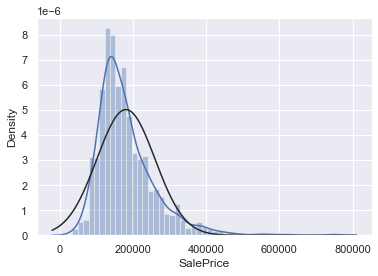

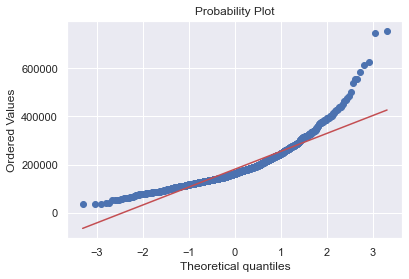

In [24]:
#histogram and normal probability plot
sns.distplot(df_train['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['SalePrice'], plot=plt)

由上图，可以观察到，显然房价本身并不是一个正态分布。
可以考虑进行一个log的非线性变换。

In [25]:
#applying log transformation
df_train['SalePrice'] = np.log(df_train['SalePrice'])

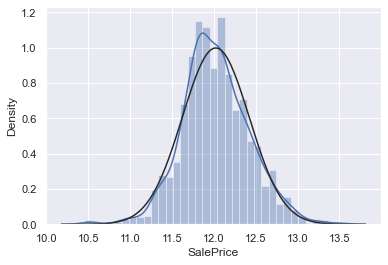

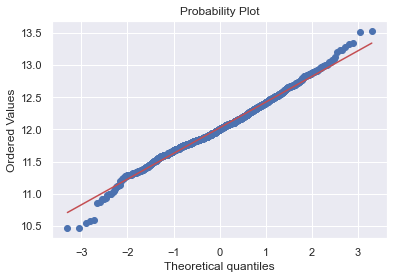

In [28]:
#transformed histogram and normal probability plot
sns.distplot(df_train['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['SalePrice'], plot=plt)

非线性变换之后，就正态分布了。
看看GrLivArea如何。

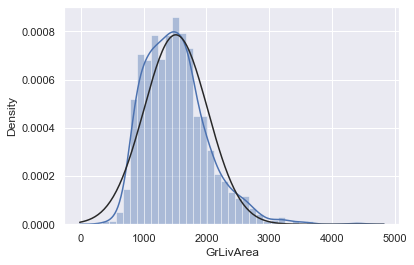

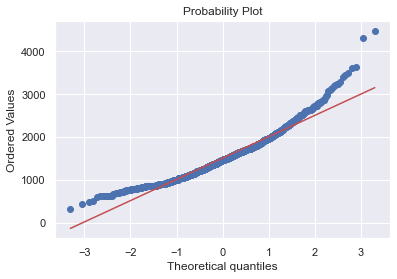

In [31]:
#histogram and normal probability plot
sns.distplot(df_train['GrLivArea'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['GrLivArea'], plot=plt)

尝试log非线性变换后：

In [33]:
#data transformation
df_train['GrLivArea'] = np.log(df_train['GrLivArea'])

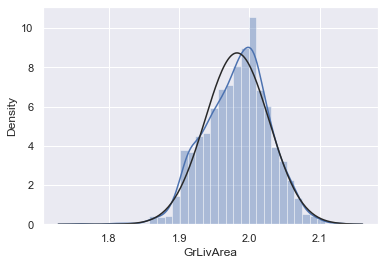

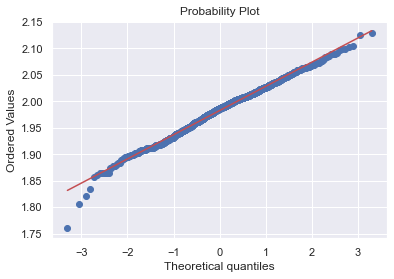

In [36]:
#transformed histogram and normal probability plot
sns.distplot(df_train['GrLivArea'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['GrLivArea'], plot=plt)

变换后，更符合正态分布了。
对于地下室空间:

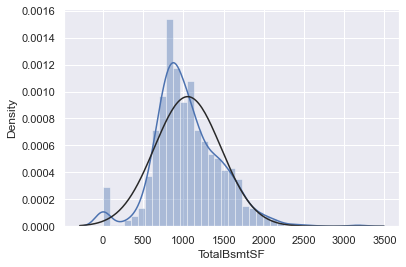

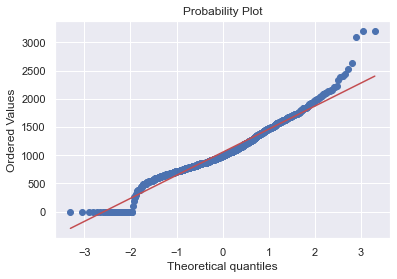

In [39]:
#histogram and normal probability plot
sns.distplot(df_train['TotalBsmtSF'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['TotalBsmtSF'], plot=plt)

地下室空间的数据可以直接使用。

现在，我们需要处理一个更难的问题：
* 出现偏斜的特征
* 出现大量“0”的特征（无法进行log非线性变换）

可以考虑保留0，其余数据进行非线性变换。这个操作可能不严谨，但是会有较好的结果。


In [42]:
#create column for new variable (one is enough because it's a binary categorical feature)
#if area>0 it gets 1, for area==0 it gets 0
df_train['HasBsmt'] = pd.Series(len(df_train['TotalBsmtSF']), index=df_train.index)
df_train['HasBsmt'] = 0 
df_train.loc[df_train['TotalBsmtSF']>0,'HasBsmt'] = 1

In [43]:
#transform data
df_train.loc[df_train['HasBsmt']==1,'TotalBsmtSF'] = np.log(df_train['TotalBsmtSF'])

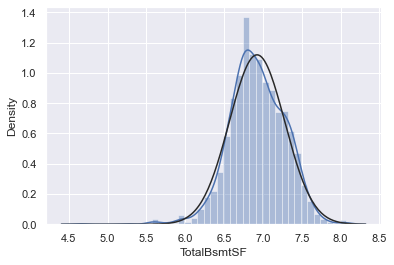

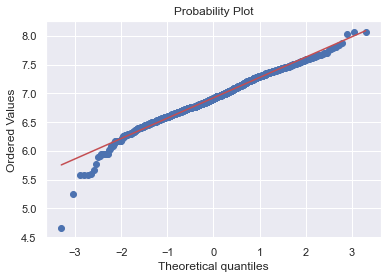

In [45]:
#histogram and normal probability plot
sns.distplot(df_train[df_train['TotalBsmtSF']>0]['TotalBsmtSF'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train[df_train['TotalBsmtSF']>0]['TotalBsmtSF'], plot=plt)

### 等方差测试

可以用散点图来检测等方差。散点图往往呈现锥形或者钻石形。

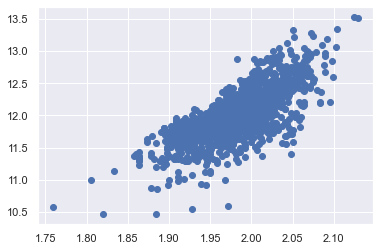

In [47]:
#scatter plot
plt.scatter(df_train['GrLivArea'], df_train['SalePrice']);


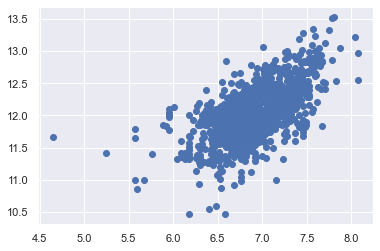

In [49]:
plt.scatter(df_train[df_train['TotalBsmtSF']>0]['TotalBsmtSF'], df_train[df_train['TotalBsmtSF']>0]['SalePrice']);

## 最后dummy variables

将离散的类别拆分出来。这个是深度学习的基操。

In [51]:
df_train = pd.get_dummies(df_train)